# Project Proposal

## Title: Influences of Employee Attrition



## Introduction:


Within the human resources (HR) department of companies, there is a record kept of every employee that has ever worked in said company, some data including their job role, level of education and job satisfaction, to name a few. One of the most important variables that is kept track of in these records is the attrition of the employees, whether or not an employee ended up leaving the company. HR data analysts can compile this data and analyze it to help the management team determine what makes for an ideal employee to hire, and how to retain employees. They can do this by looking at what factors cause employees to stay in the said company and which factors generally cause employees to leave. The data set our group is analyzing is fictional, yet realistic, and was created by an HR data analyst for a company who was interested in determining the factors relating to the employee attrition.  

For our group project, we would like to propose the following research question:

#### “Can we determine whether or not there will be employee attrition based on the hourly rate of pay and time spent working for a company of an employee?”


## Preliminary exploratory data analysis:

Below are the steps to tidying our data by isolating important variables and eliminating irrelevant variables, no missing values present. To ensure no bias in our analysis, we also created a standardization recipe. 

In [3]:
install.packages("kknn")
install.packages("themis")
library(tidyverse)
library(repr)
library(kknn)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
attrition_data<-read.csv ("https://raw.githubusercontent.com/wenshanli1231/DSCI-Group-Project/main/Employee-Attrition.csv")
attrition_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,⋯,2,80,1,6,0,3,6,2,0,3
49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,⋯,4,80,0,17,3,2,9,6,0,8
34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,⋯,1,80,0,6,3,4,4,3,1,2


In [5]:
attrition_data <- attrition_data |>
    select( Attrition, HourlyRate, YearsAtCompany)

attrition_data <- attrition_data |>
        mutate(Attrition = as_factor(Attrition))

In [6]:
attrition_split <- initial_split(attrition_data, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split) 

In [7]:
set.seed(10)


 #attrition_recipe <- recipe(Attrition~ HourlyRate + YearsAtCompany, data = attrition_train) |>
    # step_scale(all_predictors()) |>
    # step_center(all_predictors())


 #attrition_data_balanced <- attrition_recipe |>  
      #                       prep() |> 
     #                        bake(attrition_train)
rare_attrition <- bind_rows(
        filter(attrition_train, Attrition == "No"),
        attrition_train |> filter(Attrition == "Yes") |> slice_head(n=3)) |>
        select(Attrition, HourlyRate, YearsAtCompany)


attrition_recipe <- recipe (Attrition~ HourlyRate + YearsAtCompany , data= rare_attrition ) |>
    step_upsample(Attrition, over_ratio = 1, skip = FALSE) 

attrition_data_balanced <- attrition_recipe |>  
                            prep() |> 
                           bake(attrition_train)

attrition_recipe_upsampled <- recipe(Attrition~ HourlyRate + YearsAtCompany , data= attrition_data_balanced) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 



In [8]:
yeses <- attrition_data_balanced |>
    group_by (Attrition) |>
    count()
yeses

Attrition,n
<fct>,<int>
Yes,924
No,924


### Below is a summary of our tidied Employee Attrition data in one table 

In [9]:
attrition_table <- attrition_data_balanced |>
        group_by(Attrition) |>
        summarize( 
            mean_HourlyRate = mean(HourlyRate), 
            mean_YearsAtCompany = mean(YearsAtCompany), 
            count = n(), 
            count_blanks = sum(is.na(Attrition))
        )

attrition_table

Attrition,mean_HourlyRate,mean_YearsAtCompany,count,count_blanks
<fct>,<dbl>,<dbl>,<int>,<int>
Yes,63.90368,5.109307,924,0
No,65.92316,7.444805,924,0


### Below is a relevant visualization that will be used in our exploration

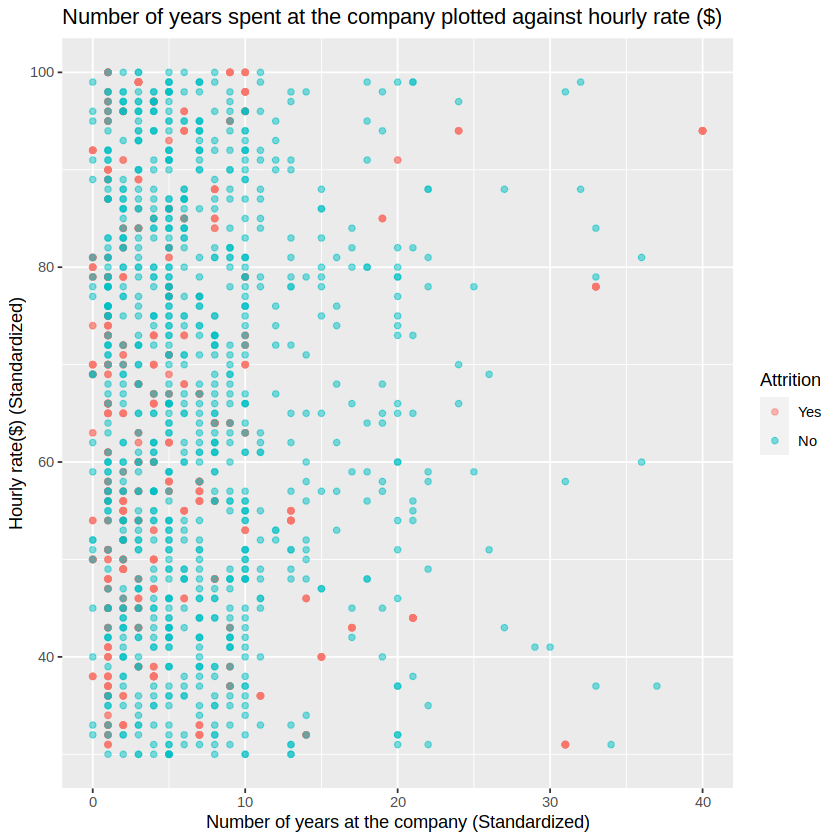

In [10]:
attrition_plot <- ggplot(attrition_data_balanced, aes(x = YearsAtCompany, y = HourlyRate, colour = Attrition)) + 
            geom_point(alpha = 0.5) +
            xlab("Number of years at the company (Standardized)") +
            ylab("Hourly rate($) (Standardized)") +
            labs(title = "Number of years spent at the company plotted against hourly rate ($)")
            
attrition_plot

## Method: 

We will conduct our data analysis by first tidying our data, and then selecting the columns of the variables we are interested in: the hourly rate earned, years worked at company, and attrition. We chose these variables because we imagine a strong correlation to employee attrition. It is commonly observed that high compensations incentivize employees to stay while the opposite for lower wages. Years working at the company also influence their decisions to stay or leave at the company since they might enjoy their higher position, their team, work environment or benefits received. On the other hand, new employees might not be as attached. Our analysis will determine if these variables are actually correlated with attrition and we plan to visualize this through a scatter plot with the years worked and hourly rate on the axis and the points colored by attrition. This way we can try and identify any patterns or trends.



## Expected outcomes and significance:

From this data, we expect to find an association between our established predictor variables and employee attrition, in that there will be less attrition to individuals with a higher hourly rate of pay and larger amount spent working for the company. Our data analysis will bring value to the management team in making strategic decisions on hiring the best candidates and factors to consider to retain talent. Future research could explore other categories, such as level of education, business traveling, and more to create a strong system to predict attrition and perform measures to prevent such results.  


## Tuning To Find Optimal Value of K

In [11]:
knn_tuned <- nearest_neighbor(weight_func = "rectangular",neighbors=tune())|>
                set_engine("kknn")|>
                set_mode("classification")
knn_tuned

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
attrition_vfold <- vfold_cv(attrition_data_balanced,v=5,strata=Attrition)


In [13]:
knn_result <- workflow()|>
                add_recipe(attrition_recipe_upsampled)|>
                add_model(knn_tuned) |>
                tune_grid(resamples=attrition_vfold,grid=10)|>
                collect_metrics()
knn_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8776998,5,0.006036526,Preprocessor1_Model1
1,roc_auc,binary,0.8776998,5,0.006036526,Preprocessor1_Model1
4,accuracy,binary,0.8306052,5,0.010165652,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.7670575,5,0.008548115,Preprocessor1_Model8
14,accuracy,binary,0.7001939,5,0.008723573,Preprocessor1_Model9
14,roc_auc,binary,0.7636452,5,0.008919068,Preprocessor1_Model9


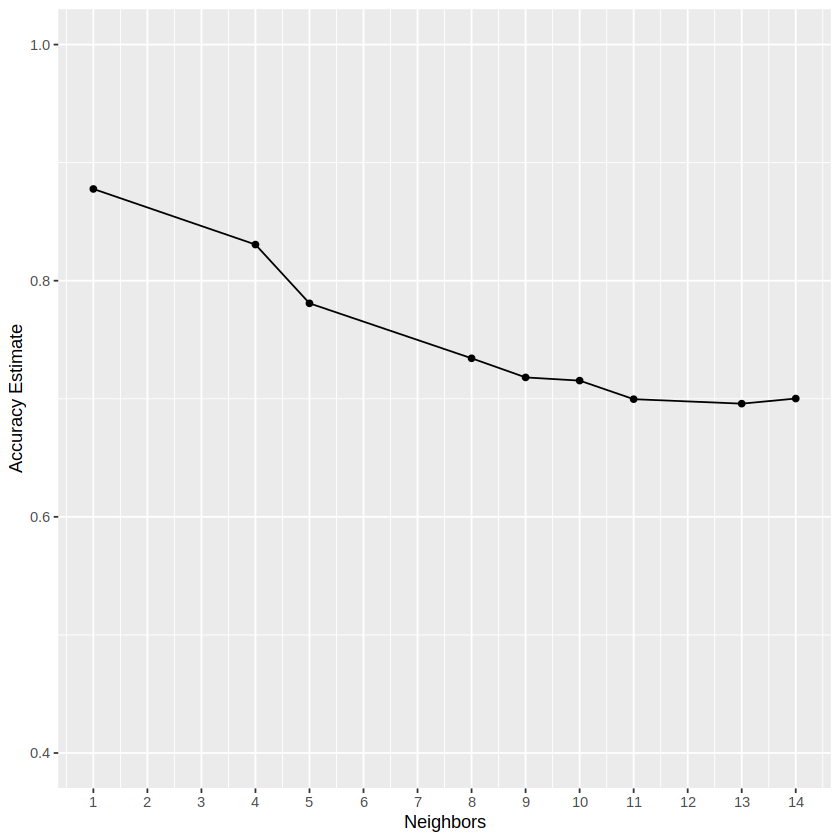

In [14]:
accuracies <- knn_result|>
                filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies,aes(x=neighbors,y=mean))+
                        geom_point()+
                        geom_line()+
                        labs(x = "Neighbors", y = "Accuracy Estimate") +
                        scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
                        scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

Since the line graph levels out at around K=6 neighbors, we will be using K=6

In [15]:
knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=6)|>
                set_engine("kknn")|>
                set_mode("classification")

In [16]:
attrition_fit <- workflow()|>
                add_recipe(attrition_recipe_upsampled)|>
                add_model(knn_spec)|>
                fit(data=attrition_train)
attrition_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1843778
Best kernel: rectangular
Best k: 6

In [17]:
attrition_test_predictions <- predict(attrition_fit,attrition_test)|>
                            bind_cols(attrition_test)
attrition_test_predictions

.pred_class,Attrition,HourlyRate,YearsAtCompany
<fct>,<fct>,<int>,<int>
No,No,40,2
No,No,81,1
No,No,67,1
⋮,⋮,⋮,⋮
No,No,98,5
No,No,74,9
No,No,82,4


In [18]:
attrition_prediction_accuracy <- attrition_test_predictions|>
                                    metrics(truth=Attrition,estimate=.pred_class)
attrition_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.80487805
kap,binary,0.07150346


In [19]:
at_mat <- attrition_test_predictions|>
                conf_mat(truth=Attrition,estimate=.pred_class)
at_mat

          Truth
Prediction Yes  No
       Yes   7  19
       No   53 290

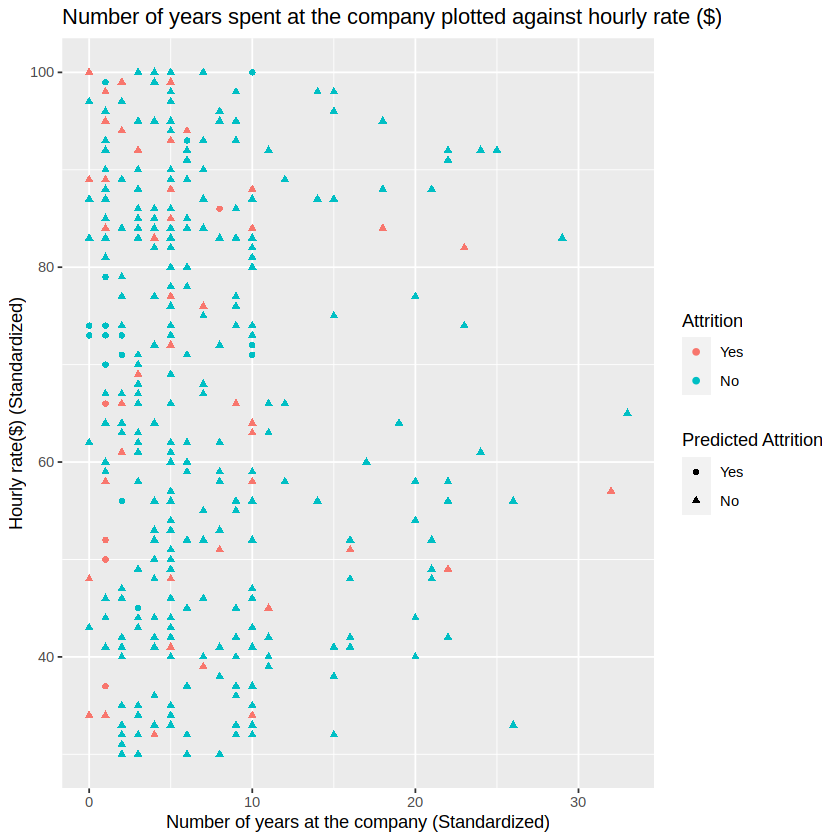

In [24]:
attrition_prediction_plot <- ggplot(attrition_test_predictions, aes(x = YearsAtCompany, y = HourlyRate, colour = Attrition, shape = .pred_class)) + 
            geom_point(alpha = 1) +
            xlab("Number of years at the company (Standardized)") +
            ylab("Hourly rate($) (Standardized)") +
            labs(title = "Number of years spent at the company plotted against hourly rate ($)",shape="Predicted Attrition")
            
attrition_prediction_plot

## Discussion:

-summarize what you found

-discuss whether this is what you expected to find?

-discuss what impact could such findings have?

-discuss what future questions could this lead to?


## References:

At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).

Make sure to cite the source of your data as well